Here we want to find out if the AlphaFold2 structures are in the "closed" or "open" conformation and look at how much they contribute to the variability observed.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu

In [25]:
cl = pd.read_csv('./project_pipeline/data/classified_files.tsv', sep='\t')

afinf = pd.read_csv('./project_pipeline/data/alphafold_interface.tsv', sep='\t')

rmsd = pd.read_csv('./project_pipeline/data/rmsds.tsv', sep='\t').astype('object')
rmsdSub = rmsd[['uniprot', 'pdb', '1_aligned']]
cl = cl.merge(rmsdSub, on=['uniprot', 'pdb'], how='left')

In [26]:
plt.style.use('science')

# Get the hex codes for the colors so we can assign them to categories
pal = sns.color_palette('Paired')
print(pal.as_hex())

# Set the color palette. Our categories are "Single Domain", "Two-Domain", and "Autoinhibitory"
colors = {'Single Domain': pal[0], 'Two-Domain': pal[1], 'Autoinhibitory': pal[2], 'Autoinhibitory (Active)': pal[2], 'Autoinhibitory (Autoinhibited)': pal[3], 
          'Full': pal[3], 'Clusters': pal[7], 'Two-State AI': pal[4], 'Autoinhibitory (Closed)': pal[5], 'Autoinhibitory (Open)': pal[4],
          'AI Predicted Open': pal[6], 'AI Predicted Closed': pal[7]}
pal.as_hex()

['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']


['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

In [27]:
# Assign uniprot conformations. Closed if any interface residues, open if none.
afinf['af_conformation'] = afinf['number_interface_residues'].apply(lambda x: 'Closed' if x > 0 else 'Open')

In [45]:
# Add to classified files
af_conf = afinf[['uniprot', 'af_conformation']]
merge = pd.merge(cl, af_conf, on='uniprot', how='left')

merge = merge.drop(columns=['organism', 'date', 'notes'])

merge.head()

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,state,conformation,1_aligned,af_conformation
0,P04637,8f2h,364-393,102-292,30.431,100.0,100.000000,3.065,70.729,Autoinhibited,Closed,10.923,Open
1,P04637,8f2i,364-393,102-292,30.431,100.0,100.000000,3.065,70.729,Autoinhibited,Closed,10.923,Open
2,P00523,2ptk,"148-245,246-266","81-142,521-533",1.737,100.0,89.333333,1.921,3.093,Autoinhibited,Closed,1.164,Closed
3,P28482,1pme,173-196,"25-172,197-313",2.422,100.0,96.603774,1.220,6.639,Autoinhibited,Closed,5.24,Closed
4,P28482,1tvo,173-196,"25-172,197-313",2.497,100.0,100.000000,1.523,6.633,Autoinhibited,Closed,5.318,Closed


Let's get some statistics

In [29]:
uni_only = merge[['uniprot', 'af_conformation']].drop_duplicates().reset_index(drop=True)
vals = uni_only['af_conformation'].value_counts()
vals

Closed    115
Open       13
Name: af_conformation, dtype: int64

In [30]:
states = merge['state'].value_counts()
states

Autoinhibited    67
Active           30
Name: state, dtype: int64

In [31]:
confs = merge['conformation'].value_counts()
confs

Closed    116
Open       12
Name: conformation, dtype: int64

In [32]:
s_v_c = merge.groupby(['state', 'conformation']).size().unstack().fillna(0)
s_v_c

conformation,Closed,Open
state,,
Active,25,5
Autoinhibited,64,3


In [33]:
c_v_ac = merge.groupby(['conformation', 'af_conformation']).size().unstack().fillna(0)
c_v_ac

af_conformation,Closed,Open
conformation,,
Closed,110,6
Open,5,7


In [34]:
s_v_ac = merge.groupby(['state', 'af_conformation']).size().unstack().fillna(0)
s_v_ac

af_conformation,Closed,Open
state,,
Active,28,2
Autoinhibited,63,4


In [35]:
s_v_ac_v_c = merge.groupby(['state', 'af_conformation', 'conformation']).size().unstack().fillna(0)
s_v_ac_v_c

conformation                   Closed  Open
state         af_conformation              
Active        Closed             25.0   3.0
              Open                0.0   2.0
Autoinhibited Closed             62.0   1.0
              Open                2.0   2.0

What does the RMSD distribution look like for closed structures?

In [36]:
# Get the comparison data
md = pd.read_csv('./project_pipeline/data/md_rmsds.tsv', sep='\t').astype('object')

md['type'] = 'Two-Domain'
# Subset the data
mdSub = md[['uniprot', 'pdb', 'complex_rmsd', '1_aligned', '2_aligned', '2_comp', 'type']]

common_columns = ['UniProt', 'PDB', 'Full Sequence', 'IM/D1', 'FD/D2', 'IM on FD/D1 on D2', 'Type']

# Rename columns
mdSub.columns = common_columns

# Melt the data
mdPlot = pd.melt(mdSub, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
mdPlot['RMSD'] = mdPlot['RMSD'].astype(float)

In [37]:
closed = merge[merge['conformation'] == 'Closed']
closed['type'] = 'Autoinhibitory (Closed)'
closed = closed[['uniprot', 'pdb', 'complex_rmsd', '1_aligned', '2_aligned', '2_comp', 'type']]
closed.columns = common_columns
closed_melt = pd.melt(closed, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')
closed_melt['RMSD'] = closed_melt['RMSD'].astype(float)

/tmp/ipykernel_1060679/4053161127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed['type'] = 'Autoinhibitory (Closed)'


In [38]:
ope = merge[merge['conformation'] == 'Open']
ope['type'] = 'Autoinhibitory (Open)'
ope = ope[['uniprot', 'pdb', 'complex_rmsd', '1_aligned', '2_aligned', '2_comp', 'type']]
ope.columns = common_columns
ope_melt = pd.melt(ope, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')
ope_melt['RMSD'] = ope_melt['RMSD'].astype(float)

/tmp/ipykernel_1060679/833641024.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ope['type'] = 'Autoinhibitory (Open)'


In [39]:
# Concatenate the data
three_plot = pd.concat([ope_melt, closed_melt, mdPlot])

# Remove outliers
three_plot = three_plot[three_plot['RMSD'] < 200]

/tmp/ipykernel_1060679/3561054271.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM/D1_Autoinhibitory (Closed) vs. IM/D1_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:2.015e-11 U_stat=1.534e+04
FD/D2_Autoinhibitory (Closed) vs. FD/D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.645e-14 U_stat=1.604e+04


FD/D2_Autoinhibitory (Open) vs. FD/D2_Autoinhibitory (Closed): Mann-Whitney-Wilcoxon test two-sided, P_val:2.263e-01 U_stat=8.445e+02
IM on FD/D1 on D2_Autoinhibitory (Closed) vs. IM on FD/D1 on D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.026e-07 U_stat=1.434e+04
IM on FD/D1 on D2_Autoinhibitory (Open) vs. IM on FD/D1 on D2_Autoinhibitory (Closed): Mann-Whitney-Wilcoxon test two-sided, P_val:5.971e-04 U_stat=1.039e+03
Full Sequence_Autoinhibitory (Closed) vs. Full Sequence_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:2.083e-13 U_stat=1.580e+04
Full Sequence_Autoinhibitory (Open) vs. Full Sequence_Autoinhibitory (Closed): Mann-Whitney-Wilcoxon test two-sided, P_val:1.625e-03 U_stat=1.082e+03
IM/D1_Autoinhibitory (Open) vs. IM/D1_Autoinhibitory (Closed): Mann-Whitney-Wilcoxon test two-sided, P_val:1.597e-01 U_stat=8.685e+02
FD/D2_Autoinhibitory (Open) vs. FD/D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.329e-04 U_stat=1.802e+03
IM on FD/D1 on D2

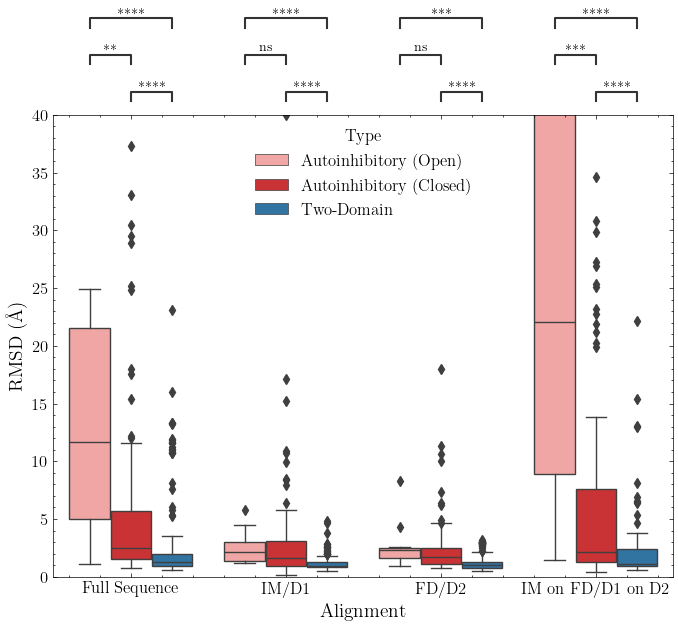

In [40]:
# Plot the data
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='Alignment', y='RMSD', hue='Type', data=three_plot, ax=ax, palette=colors)
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)


# Add the annotations, comparing between structural alignment categories
pairs = [[('Full Sequence', 'Autoinhibitory (Open)'), ('Full Sequence', 'Two-Domain')],
        [('Full Sequence', 'Autoinhibitory (Closed)'), ('Full Sequence', 'Two-Domain')],
        [('Full Sequence', 'Autoinhibitory (Open)'), ('Full Sequence', 'Autoinhibitory (Closed)')],
        [('IM/D1', 'Autoinhibitory (Open)'), ('IM/D1', 'Two-Domain')],
        [('IM/D1', 'Autoinhibitory (Closed)'), ('IM/D1', 'Two-Domain')],
        [('IM/D1', 'Autoinhibitory (Open)'), ('IM/D1', 'Autoinhibitory (Closed)')],
        [('FD/D2', 'Autoinhibitory (Open)'), ('FD/D2', 'Two-Domain')],
        [('FD/D2', 'Autoinhibitory (Closed)'), ('FD/D2', 'Two-Domain')],
        [('FD/D2', 'Autoinhibitory (Open)'), ('FD/D2', 'Autoinhibitory (Closed)')],
        [('IM on FD/D1 on D2', 'Autoinhibitory (Open)'), ('IM on FD/D1 on D2', 'Two-Domain')],
        [('IM on FD/D1 on D2', 'Autoinhibitory (Closed)'), ('IM on FD/D1 on D2', 'Two-Domain')],
        [('IM on FD/D1 on D2', 'Autoinhibitory (Open)'), ('IM on FD/D1 on D2', 'Autoinhibitory (Closed)')]]
subcat_order = ['Full Sequence', 'IM/D1', 'FD/D2', 'IM on FD/D1 on D2']
annotator = Annotator(ax, pairs, data=three_plot, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/by_conformation_rmsd.png', dpi=500, bbox_inches='tight')
plt.show()

How many of our structures with differences between the predicted and experimental of greater than 20 come from the open, closed, active, and autoinhibited?

In [41]:
bigdif = merge[merge['2_comp'] > 20]
bigdif_cl = bigdif.groupby(['state', 'conformation']).size().unstack().fillna(0)
print(len(bigdif))
bigdif_cl

26


conformation,Closed,Open
state,,
Active,4,3
Autoinhibited,8,2


How much are the variations between our closed AlphaFold2 structures and our open AlphaFold2 structures?

In [42]:
af_closed = merge[merge['af_conformation'] == 'Closed']
af_closed['type'] = 'AI Predicted Closed'
af_closed = af_closed[['uniprot', 'pdb', 'complex_rmsd', '1_aligned', '2_aligned', '2_comp', 'type']]
af_closed.columns = common_columns
af_closed_melt = pd.melt(af_closed, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')
af_closed_melt['RMSD'] = af_closed_melt['RMSD'].astype(float)

af_ope = merge[merge['af_conformation'] == 'Open']
af_ope['type'] = 'AI Predicted Open'
af_ope = af_ope[['uniprot', 'pdb', 'complex_rmsd', '1_aligned', '2_aligned', '2_comp', 'type']]
af_ope.columns = common_columns
af_ope_melt = pd.melt(af_ope, id_vars=['UniProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')
af_ope_melt['RMSD'] = af_ope_melt['RMSD'].astype(float)

/tmp/ipykernel_1060679/2451765563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  af_closed['type'] = 'AI Predicted Closed'
/tmp/ipykernel_1060679/2451765563.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  af_ope['type'] = 'AI Predicted Open'


In [43]:
# Concatenate the data
af_three_plot = pd.concat([af_ope_melt, af_closed_melt, mdPlot])

# Remove outliers
af_three_plot = af_three_plot[af_three_plot['RMSD'] < 100]

/tmp/ipykernel_1060679/956262436.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM/D1_AI Predicted Closed vs. IM/D1_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:2.391e-11 U_stat=1.520e+04
FD/D2_AI Predicted Closed vs. FD/D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:8.738e-14 U_stat=1.576e+04
FD/D2_AI Predicted Open vs. FD/D2_AI Predicted Closed: Mann-Whitney-Wilcoxon test two-sided, P_val:6.981e-03 U_stat=1.090e+03
IM on FD/D1 on D2_AI Predicted Closed vs. IM on FD/D1 on D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:3.141e-07 U_stat=1.397e+04
IM on FD/D1 on D2_AI Predicted Open vs. IM on FD/D1 on D2_AI Predicted Closed: Mann-Whitney-Wilcoxon test two-sided, P_val:2.656e-05 U_stat=1.190e+03
Full Sequence_AI Predicted Closed vs. Full Sequence_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:4.948e-13 U_stat=1.560e+04
Full Sequence_AI

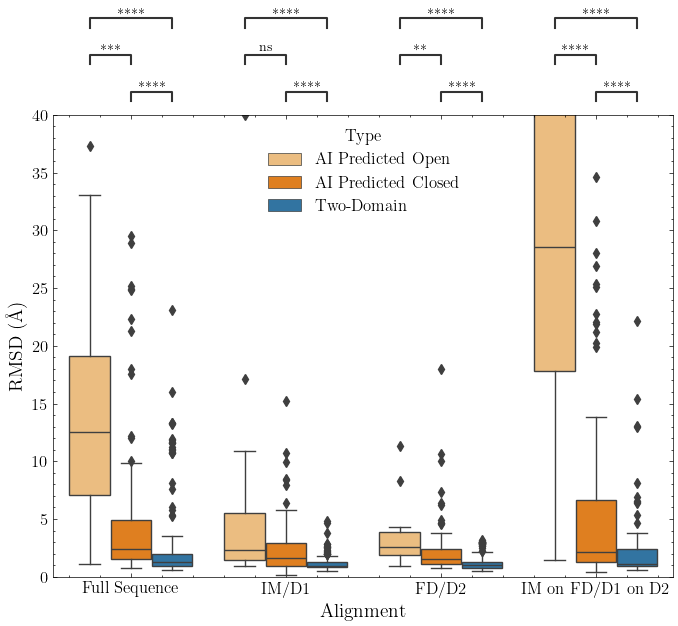

In [44]:
# Plot the data
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='Alignment', y='RMSD', hue='Type', data=af_three_plot, ax=ax, palette=colors)
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)


# Add the annotations, comparing between structural alignment categories
pairs = [[('Full Sequence', 'AI Predicted Open'), ('Full Sequence', 'Two-Domain')],
        [('Full Sequence', 'AI Predicted Closed'), ('Full Sequence', 'Two-Domain')],
        [('Full Sequence', 'AI Predicted Open'), ('Full Sequence', 'AI Predicted Closed')],
        [('IM/D1', 'AI Predicted Open'), ('IM/D1', 'Two-Domain')],
        [('IM/D1', 'AI Predicted Closed'), ('IM/D1', 'Two-Domain')],
        [('IM/D1', 'AI Predicted Open'), ('IM/D1', 'AI Predicted Closed')],
        [('FD/D2', 'AI Predicted Open'), ('FD/D2', 'Two-Domain')],
        [('FD/D2', 'AI Predicted Closed'), ('FD/D2', 'Two-Domain')],
        [('FD/D2', 'AI Predicted Open'), ('FD/D2', 'AI Predicted Closed')],
        [('IM on FD/D1 on D2', 'AI Predicted Open'), ('IM on FD/D1 on D2', 'Two-Domain')],
        [('IM on FD/D1 on D2', 'AI Predicted Closed'), ('IM on FD/D1 on D2', 'Two-Domain')],
        [('IM on FD/D1 on D2', 'AI Predicted Open'), ('IM on FD/D1 on D2', 'AI Predicted Closed')]]
subcat_order = ['Full Sequence', 'IM/D1', 'FD/D2', 'IM on FD/D1 on D2']
annotator = Annotator(ax, pairs, data=af_three_plot, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('./project_pipeline/data/figures/by_af_conformation_rmsd.png', dpi=500, bbox_inches='tight')
plt.show()